In [1]:
# Machine learning: 
# Benchmark - Linear regression
# Sklearn pipelines
# cv + grid search
# ML algorithms: Decision Tree, RandomForest
# Comparing models: R^2 , MAE, MSE

In [2]:
import os

import pandas as pd
import cufflinks as cf; cf.go_offline() # Visualization

import matplotlib.pyplot as plt
import plotly.express as px

import re
import regex

import seaborn as sns

%matplotlib inline

import numpy as np
import string

In [3]:
import nltk

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\missm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\missm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# loading the wine_reviews csv into DataFrame 'data'

url = "winemag-data-130k-v2_EDA.csv"
wine_reviews = pd.read_csv(url)
data = wine_reviews

In [8]:
wine_reviews.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery', 'vintage',
       'avg points variety', 'avg points winery', 'pureTextdescription'],
      dtype='object')

In [9]:
# Bag of words

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
wine_reviews.shape

(83612, 18)

In [12]:
# preparing the dataset for a machine learning

wine_reviews_lean = wine_reviews[['country','points', 'price', 'taster_name', 'variety', 'winery',
                                 'vintage', 'avg points variety', 'avg points winery',
                                 'pureTextdescription']]
target = 'points'
test_df, train_df = train_test_split(wine_reviews_lean, test_size=0.8, random_state=42)
train_df.dropna(axis=0, inplace=True)
test_df.dropna(axis=0, inplace=True)

train_df.shape, test_df.shape

((66890, 10), (16722, 10))

In [13]:
# splitting into training and testing

X_train, y_train = train_df.drop(target, axis=1), train_df[[target]]
X_test, y_test = test_df.drop(target, axis=1), test_df[[target]]

X_train.head()

,country,price,taster_name,variety,winery,vintage,avg points variety,avg points winery,pureTextdescription
14856,australia,20.000000,joe czerwinski,riesling,penfolds,2007,89.668089,90.723404,"better known for its red wines, penfolds has t..."
35174,us,75.000000,unknown,cabernet sauvignon,raymond,2008,88.806511,89.149254,"a lovely cabernet, rich and ripe in blackberri..."
44851,france,45.000000,roger voss,rosé,château coussin,2016,86.895338,88.461538,named after césar the sculptor and not caesar ...
12814,us,60.000000,virginie boone,syrah,pride mountain,2013,89.511190,90.900000,"co-fermented with a small amount of viognier, ..."
40627,portugal,36.736747,roger voss,port,cálem,2011,90.584906,88.750000,"a solid, ripe, fruity wine, rich in tannins th..."


In [14]:
# list of stopwords to remove

stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [15]:
# tokenizing each description into words and filtering out stopwords:

train_words = [word for description in train_df.pureTextdescription for word in nltk.word_tokenize(description) if word.lower() not in stopwords]

In [16]:
len(train_words)

2146687

In [17]:
unique_train_words = set(train_words)
print(len(unique_train_words))

33862


In [18]:
from nltk.stem import PorterStemmer

In [19]:
# stemming

ps = PorterStemmer()
words = train_words
words = [ps.stem(w) for w in words]

In [20]:
print(words[:5])

['better', 'known', 'red', 'wine', ',']


In [21]:
# the unique words and their corresponding counts
# include only word count greater than 20, and less than half length of the training data

words = pd.DataFrame(data = train_words, columns = ['word']).word.value_counts().reset_index()
words.columns = ['word','wordCount']
words = words[(words['wordCount']>20)&(words['wordCount']<len(X_train)/2)]
words.shape

(4710, 2)

In [22]:
words.head

<bound method NDFrame.head of            word  wordCount
3       flavors      32609
4            's      27534
5         fruit      23653
6        aromas      19653
7        palate      19484
...         ...        ...
4708    rolling         21
4709  grechetto         21
4710   forested         21
4711     swathe         21
4712     shoots         21

[4710 rows x 2 columns]>

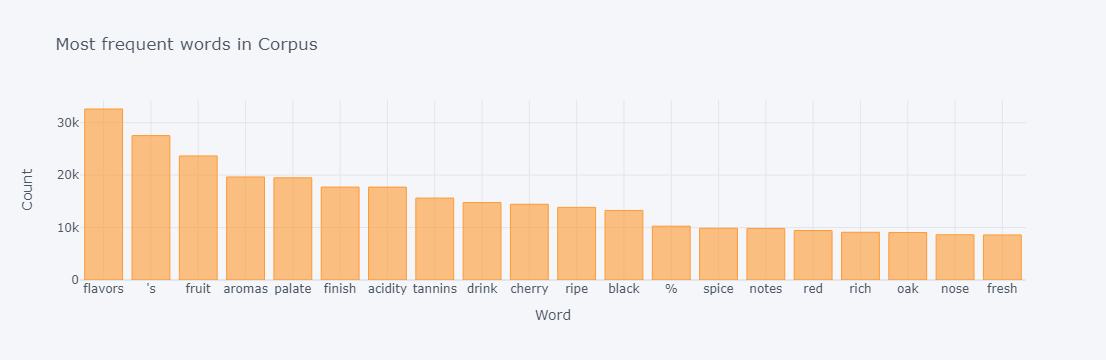

In [23]:
# interactive bar chart of most frequent words

words.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [24]:
# set vocabulary with the unique words

clean_vocab = set(words.word)
len(clean_vocab)

4710

In [25]:
# filter out very short words

clean_vocab_loop = clean_vocab.copy()
for word in clean_vocab_loop:
    if len(word)<3:
        # print(word)
        clean_vocab.remove(word)

In [26]:
len(clean_vocab)

4607

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [28]:
# preprocessing scikit-learn pipeline for the data using the ColumnTransformer

In [29]:
# Define categorical and numerical and text features

categorical_features = ['country', 'taster_name','variety']
numerical_features = ['price', 'vintage', 'avg points variety', 'avg points winery',]
des_feature = 'pureTextdescription'

In [30]:
# define transformers(processing step) for each type of feature:
# categorical features- pipeline constant 'missing' and one-hot encoding.
# numerical features- pipeline fills missing values with mean and StandardScaler.
# text feature 'pureTextdescription'- pipeline TfidfVectorizer with clean_vocab.

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

description_tansformer = Pipeline(steps=[
    ('idf', TfidfVectorizer(vocabulary = clean_vocab)),
    
])

In [31]:
# combine the transformers for different types of features using ColumnTransformer

wine_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
       ('text',description_tansformer , des_feature),
    
        ], remainder='drop')

In [32]:
# full pipeline with classifier Linear regression as benchmark

full_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('regressor', LinearRegression())
])

In [33]:
X_train.shape, y_train.shape

((66890, 9), (66890, 1))

In [34]:
# Fit the pipeline to the training data

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price', 'vintage',
                                                   'avg points variety',
                                                   'avg points winery']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['co...ter_name',
                                                   'variety']),
                                                 ('text',
                                                  Pipeline(steps=[('idf',
                                                                   TfidfVectorizer(vocabulary={"'04",
                                                                                               "'05",
                                                                                               "'06",
                                                                                               "'07",
                                                                                               "'08",
                                                                                               "'09",
                                                                                               "'ll",
                                                                                               "'re",
                                                                                               "'ve",
                                                                                               '100',
                                                                                               '10–15',
                                                                                               '12.5',
                                                                                               '15.5',
                                                                                               '1–2',
                                                                                               '2000',
                                                                                               '2001',
                                                                                               '2002',
                                                                                               '2003',
                                                                                               '2004',
                                                                                               '2005',
                                                                                               '2006',
                                                                                               '2007',
                                                                                               '2008',
                                                                                               '2009',
                                                                                               '2010',
      

In [35]:
# evaluate the performance of the model
# error - differences between predicted and the actual target
# Models were compared by R^2 and mean of absolute errors

In [36]:
# R^2 - indication between 0 and 1 of how well the features explain the target

R_2 = full_pipeline.score(X_test, y_test)
print(f"Test R^2: {R_2:.3f}")

# Initial Results - Linear regression - Test R^2: 0.78

Test R^2: 0.780


In [37]:
# MAE - mean absolute error

np.mean(abs(full_pipeline.predict(X_test)-y_test))

# Initial Results - Linear regression - Test MAE: 1.13

points    1.133218
dtype: float64

In [38]:
# MSE - mean squared error

np.mean((full_pipeline.predict(X_test) - y_test) ** 2)

# Initial Results - Linear regression - Test MSE: 2.08

points    2.08011
dtype: float64

In [39]:
# Grid of hyperparameters - to find the best set of hyperparameters
# using cross-validation on different subsets of the data

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge,Lasso

In [41]:
# list of dictionaries, where each dictionary corresponds to a set of hyperparameters for a specific regression model:
# ML algorithms: Decision Tree, RandomForest

wine_param_grid = [
    {
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False] # true false- whether or not the model should fit bias
    },
    {
        'regressor': [DecisionTreeRegressor()],
        'regressor__max_depth': [8,9,10,11,12,13],
        'regressor__min_samples_leaf':[29,30,32], # minimum number of samples  
    },
    
    {
        'regressor':[Lasso()],
        'regressor__alpha':[0.1, 1.0, 10, 100] # regularization strength
    },
    
     {
         'regressor':[Ridge()],
         'regressor__alpha':np.arange(0.5, 0.7, 0.05)
     },
    {
        'regressor':[RandomForestRegressor()],
        'regressor__max_depth': [10,11],
        'regressor__min_samples_leaf':[10,30]
    },
]

In [42]:
# store the results of the grid search
# fits the GridSearchCV object to the training data

grid_search = GridSearchCV(full_pipeline, wine_param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price',
                                                                          'vintage',
                                                                          'avg '
                                                                          'points '
                                                                          'variety',
                                                                          'avg '
                                                                          'points '
                                                                          'winery']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEnco...
                          'regressor__max_depth': [8, 9, 10, 11, 12, 13],
                          'regressor__min_samples_leaf': [29, 30, 32]},
                         {'regressor': [Lasso()],
                          'regressor__alpha': [0.1, 1.0, 10, 100]},
                         {'regressor': [Ridge(alpha=0.55)],
                          'regressor__alpha': array([0.5 , 0.55, 0.6 , 0.65])},
                         {'regressor': [RandomForestRegressor()],
                          'regressor__max_depth': [10, 11],
                          'regressor__min_samples_leaf': [10, 30]}],
             scoring='r2', verbose=2)

In [43]:
# the highest mean score achieved for the best model configuration 

grid_search.best_score_

0.7728055603897588

In [44]:
# best parameters

grid_search.best_params_

{'regressor': Ridge(alpha=0.55), 'regressor__alpha': 0.55}

In [45]:
# evaluate the performance of the model:

In [46]:
# R^2 prediction

R_2 = grid_search.score(X_test, y_test)
print(f"Test R^2: {R_2:.3f}")

# result Linear regression with Ridge regularization - Test R^2: 0.782

Test R^2: 0.782


In [47]:
# MAE - mean absolute error

np.mean(abs(grid_search.predict(X_test)-y_test))

# result MAE Linear regression with Ridge regularization: 1.128

points    1.128399
dtype: float64

In [48]:
# MSE - mean squared error

np.mean((full_pipeline.predict(X_test) - y_test) ** 2)

# result MSE Linear regression with Ridge regularization: 2.08

points    2.08011
dtype: float64

In [49]:
# line plot:

In [50]:
# regressors list comprehension extracts a list of the hyperparameter configurations used in the grid search

regressors = [str(reg.values()).split('dict_values(')[1] for reg in grid_search.cv_results_['params']]

In [51]:
# stores the mean test scores represent the R-squared for each model configuration

r2s = grid_search.cv_results_['mean_test_score']

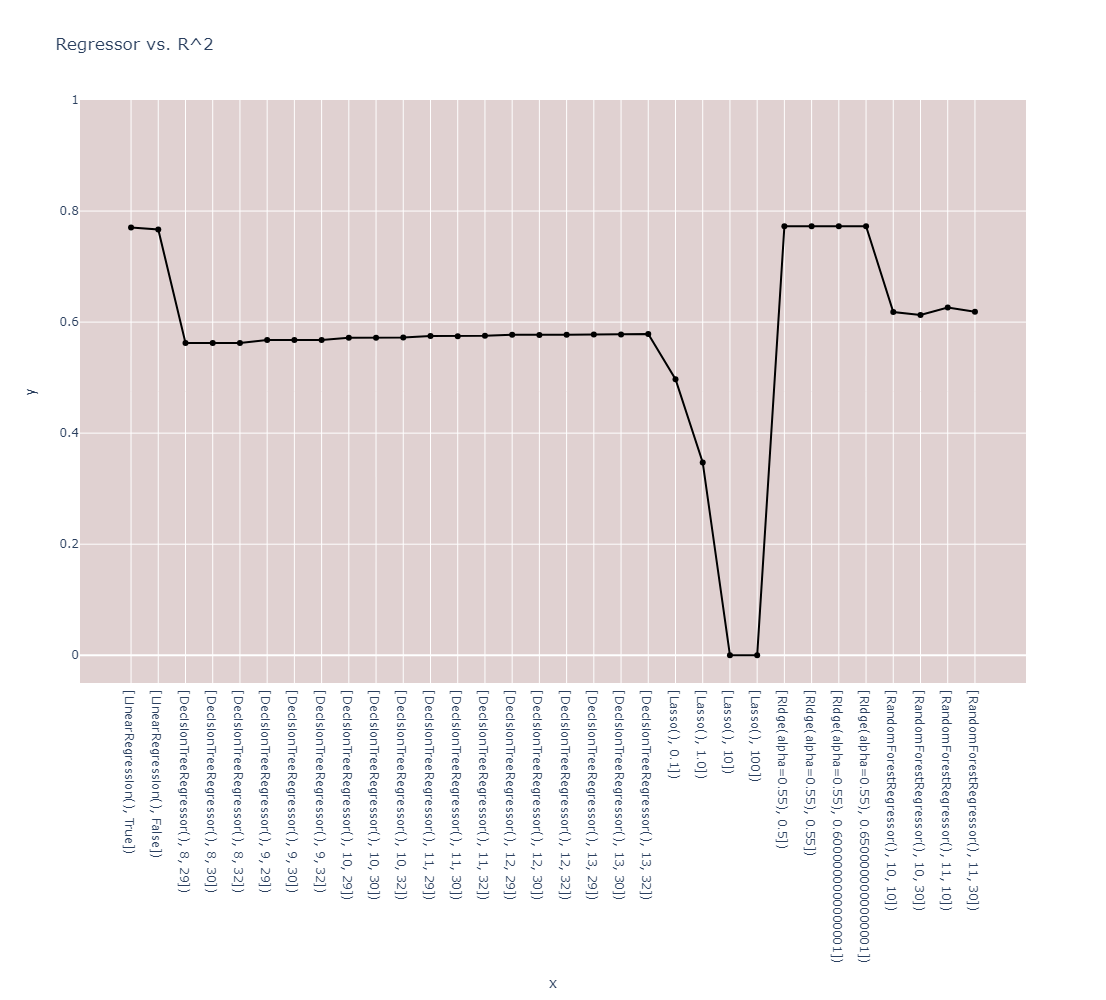

In [52]:
# line plot visualize the relationship between regressors and their R-squared scores:

fig = px.line(x=regressors,y=r2s,range_y=(-0.05,1),width=1000,height=1000,labels=True,
              title='Regressor vs. R^2', markers=True,color_discrete_sequence=['black'],)
fig.update_layout({  # more update settings
'plot_bgcolor': 'rgba(0.4, 0.1, 0.1, 0.2)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})